# Model Training on processed Amsterdam data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

### Load data

In [2]:
path='C:/Zcommon/trainee/project_1/mlpreprocessed.csv'
df=pd.read_csv(path)


## Split into Features and target.

In [3]:
X=df.drop(columns=['price','id','name'])
y=np.log1p(df['price'])

## Taking log1p for price as it has many huge outliers which skew the data big time, and so inorder to have unbiased modeling we have to shrink price a bit, after the calculations it will be returned to normal and actual values will be displayed in accordance with the currency.

# Split

In [4]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# @Random Forest Regression

In [5]:
rf=RandomForestRegressor(n_estimators=600,max_depth=20,random_state=42)


In [6]:
rf.fit(X_train,y_train)

,n_estimators,600
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Predict

In [7]:
rf_pred=rf.predict(X_test)

## Evaluation

In [8]:
mae_rf = mean_absolute_error(y_test, rf_pred)
rmse_rf = root_mean_squared_error(y_test, rf_pred)

print("MAE:", mae_rf)
print("RMSE:", rmse_rf)

MAE: 0.23477161724829437
RMSE: 0.3454420334309977


## Converting to real currecy and evaluating

In [9]:
# convert both predictions and true values back to actual price
predsrf = np.expm1(rf_pred)       # model output → real price
true_y = np.expm1(y_test)         # original y → real price

# compute real-space metrics
mae_real = mean_absolute_error(true_y, predsrf)
rmse_real = root_mean_squared_error(true_y, predsrf)

print(f"Real-Euro MAE (€): {mae_real:.2f}")
print(f"Real-Euro RMSE (€): {rmse_real:.2f}")

Real-Euro MAE (€): 132.89
Real-Euro RMSE (€): 2326.36


In [10]:
true_prices = np.expm1(y_test)

comparison = pd.DataFrame({
    "Actual_Price": true_prices,
    "Predicted_Price": predsrf
})
comparison.head(20)

,Actual_Price,Predicted_Price
1374,86.0,121.509517
808,288.0,225.908976
4842,407.0,278.781583
23,948.0,910.882722
755,125.0,229.144793
3326,271.0,241.438169
3815,92.0,109.118806
3090,178.0,232.834066
5039,405.0,306.379742
3795,80018.0,550.046836


# XGB Regression

In [11]:
xgb=XGBRegressor()

In [12]:
xgb.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Predict

In [13]:
xgb_pred=xgb.predict(X_test)

## Evaluation

In [14]:
mae_xgb = mean_absolute_error(y_test, xgb_pred)
rmse_xgb = root_mean_squared_error(y_test, xgb_pred)

print("MAE:", mae_xgb)
print("RMSE:", rmse_xgb)

MAE: 0.2345321676410658
RMSE: 0.3382817695575286


## Converting to real currecy and evaluating

In [15]:
# convert both predictions and true values back to actual price
predsxgb = np.expm1(xgb_pred)     # model output → real price
true_y = np.expm1(y_test)         # original y → real price

# compute real-space metrics
mae_real = mean_absolute_error(true_y, predsxgb)
rmse_real = root_mean_squared_error(true_y, predsxgb)

print(f"Real-Euro MAE (€): {mae_real:.2f}")
print(f"Real-Euro RMSE (€): {rmse_real:.2f}")

Real-Euro MAE (€): 133.37
Real-Euro RMSE (€): 2321.29


### An rmse value this huge in real currency is common here as there are some very expensive lsitings that are influencing this factor but there is no problem in predicting other listings. The same goes for other models as well.

In [16]:
true_prices = np.expm1(y_test)

comparison = pd.DataFrame({
    "Actual_Price": true_prices,
    "Predicted_Price": predsxgb
})
comparison.head(20)

,Actual_Price,Predicted_Price
1374,86.0,105.684830
808,288.0,287.042175
4842,407.0,322.312958
23,948.0,777.747742
755,125.0,190.053223
3326,271.0,235.673477
3815,92.0,90.757027
3090,178.0,238.040741
5039,405.0,385.659821
3795,80018.0,718.882996


# @LGBM Regression

In [17]:
lgb=LGBMRegressor(objective="regression",
    boosting_type="gbdt",
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=64,
    min_data_in_leaf=25,
    lambda_l1=1.2,
    lambda_l2=2.5,
    subsample=0.85,
    colsample_bytree=0.8,
    feature_fraction=0.8,
    bagging_fraction=0.85,
    bagging_freq=3)

In [18]:
lgb.fit(X_train,y_train)

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2
[LightGBM] [Warning] lambda_l2 is set=2.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.85 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fracti

,boosting_type,'gbdt'
,num_leaves,64
,max_depth,-1
,learning_rate,0.03
,n_estimators,1200
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## Predict

In [19]:
lgb_pred=lgb.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2
[LightGBM] [Warning] lambda_l2 is set=2.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.85 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


## Evaluation

In [20]:
mae_lgb = mean_absolute_error(y_test, lgb_pred)
rmse_lgb = root_mean_squared_error(y_test, lgb_pred)

print("MAE:", mae_lgb)
print("RMSE:", rmse_lgb)

MAE: 0.21567980970267817
RMSE: 0.3175730454540975


In [21]:
# convert both predictions and true values back to actual price
predslgb = np.expm1(lgb_pred)     # model output → real price
true_y = np.expm1(y_test)         # original y → real price

# compute real-space metrics
mae_real = mean_absolute_error(true_y, predslgb)
rmse_real = root_mean_squared_error(true_y, predslgb)

print(f"Real-Euro MAE (€): {mae_real:.2f}")
print(f"Real-Euro RMSE (€): {rmse_real:.2f}")

Real-Euro MAE (€): 127.54
Real-Euro RMSE (€): 2310.51


## Converting to real currecy and evaluating

In [22]:
true_prices = np.expm1(y_test)

comparison = pd.DataFrame({
    "Actual_Price": true_prices,
    "Predicted_Price": predslgb
})
comparison.head(20)

,Actual_Price,Predicted_Price
1374,86.0,96.847485
808,288.0,283.884645
4842,407.0,284.814807
23,948.0,981.611500
755,125.0,209.200937
3326,271.0,239.932093
3815,92.0,100.534035
3090,178.0,218.373786
5039,405.0,311.522798
3795,80018.0,1077.534467


# @CatBoost Regression

In [23]:
cat=CatBoostRegressor()

In [24]:
cat.fit(X_train,y_train)

Learning rate set to 0.052249
0:	learn: 0.5581591	total: 143ms	remaining: 2m 22s
1:	learn: 0.5475887	total: 145ms	remaining: 1m 12s
2:	learn: 0.5374885	total: 148ms	remaining: 49.3s
3:	learn: 0.5287945	total: 151ms	remaining: 37.7s
4:	learn: 0.5192414	total: 155ms	remaining: 30.8s
5:	learn: 0.5114241	total: 158ms	remaining: 26.1s
6:	learn: 0.5035518	total: 160ms	remaining: 22.7s
7:	learn: 0.4957608	total: 163ms	remaining: 20.2s
8:	learn: 0.4892479	total: 166ms	remaining: 18.3s
9:	learn: 0.4830637	total: 169ms	remaining: 16.7s
10:	learn: 0.4769143	total: 172ms	remaining: 15.4s
11:	learn: 0.4714556	total: 175ms	remaining: 14.4s
12:	learn: 0.4664333	total: 178ms	remaining: 13.5s
13:	learn: 0.4610768	total: 180ms	remaining: 12.7s
14:	learn: 0.4561560	total: 183ms	remaining: 12s
15:	learn: 0.4514546	total: 187ms	remaining: 11.5s
16:	learn: 0.4466941	total: 190ms	remaining: 11s
17:	learn: 0.4420815	total: 193ms	remaining: 10.5s
18:	learn: 0.4383111	total: 196ms	remaining: 10.1s
19:	learn: 0.

## Predict

In [25]:
cat_pred=cat.predict(X_test)

## Evaluation

In [26]:
mae_cat = mean_absolute_error(y_test, cat_pred)
rmse_cat = root_mean_squared_error(y_test, cat_pred)

print("MAE:", mae_cat)
print("RMSE:", rmse_cat)

MAE: 0.2059690609477845
RMSE: 0.30240133802419644


In [27]:
# convert both predictions and true values back to actual price
predscat = np.expm1(cat_pred)     # model output → real price
true_y = np.expm1(y_test)         # original y → real price

# compute real-space metrics
mae_real = mean_absolute_error(true_y, predscat)
rmse_real = root_mean_squared_error(true_y, predscat)

print(f"Real-Euro MAE (€): {mae_real:.2f}")
print(f"Real-Euro RMSE (€): {rmse_real:.2f}")

Real-Euro MAE (€): 124.27
Real-Euro RMSE (€): 2308.78


## Converting to real currecy and evaluating

In [28]:
true_prices = np.expm1(y_test)

comparison = pd.DataFrame({
    "Actual_Price": true_prices,
    "Predicted_Price": predscat
})
comparison.head(20)

,Actual_Price,Predicted_Price
1374,86.0,94.194081
808,288.0,302.113567
4842,407.0,280.253556
23,948.0,926.358195
755,125.0,218.858291
3326,271.0,240.448032
3815,92.0,101.035958
3090,178.0,216.019060
5039,405.0,328.409329
3795,80018.0,1125.839585


# Taking the best scores of all models(by best means with or without internal tuning regression parameters, whichever brings more favourable results).


📊 MODEL PERFORMANCE RANKING:
          Model       MAE      RMSE  Rank
0      CatBoost  0.205969  0.302401   1.0
1      LightGBM  0.215680  0.317573   2.0
2       XGBoost  0.234532  0.338282   3.0
3  RandomForest  0.234772  0.345442   4.0


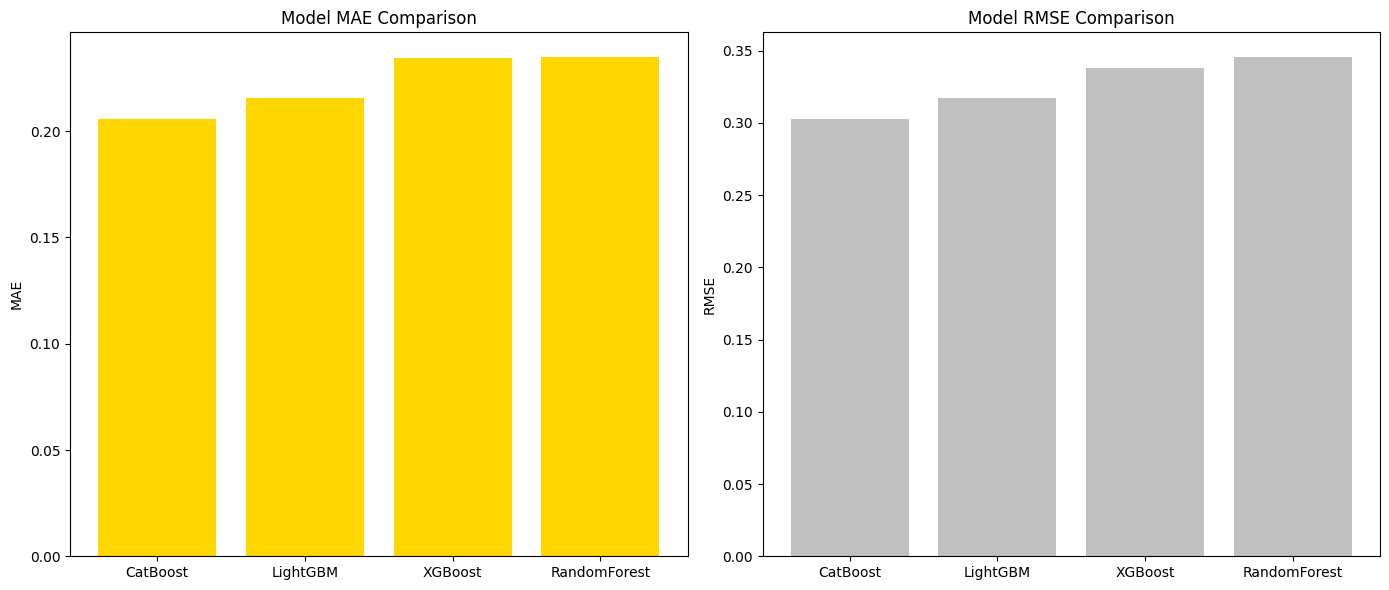

In [29]:
mae_scores = {
    "XGBoost": mae_xgb,
    "RandomForest": mae_rf,
    "LightGBM": mae_lgb,
    "CatBoost": mae_cat
}
rmse_scores = {
    "XGBoost": rmse_xgb,
    "RandomForest": rmse_rf,
    "LightGBM": rmse_lgb,
    "CatBoost": rmse_cat
}
# BUILD PERFORMANCE TABLE
ranking_df = pd.DataFrame({
    "Model": list(mae_scores.keys()),
    "MAE": list(mae_scores.values()),
    "RMSE": list(rmse_scores.values())
})

# COMBINED RANK (true 1,2,3,4 ranking)
ranking_df["Rank"] = ranking_df[["MAE", "RMSE"]].mean(axis=1).rank(method="dense")

# Sort by rank
ranking_df = ranking_df.sort_values("Rank").reset_index(drop=True)

print("\n📊 MODEL PERFORMANCE RANKING:")
print(ranking_df)

# PLOTTING
plt.figure(figsize=(14,6))

# MAE plot
plt.subplot(1,2,1)
plt.bar(ranking_df["Model"], ranking_df["MAE"], color='gold')
plt.title("Model MAE Comparison")
plt.ylabel("MAE")

# RMSE plot
plt.subplot(1,2,2)
plt.bar(ranking_df["Model"], ranking_df["RMSE"], color='silver')
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE")

plt.tight_layout()
plt.show()


# CatBoost achieved the best predictive performance with the lowest MAE (0.1067) and RMSE (0.1850) on log-transformed price values.
# LightGBM and XGBoost performed similarly but slightly worse.
# RandomForest showed the weakest performance, indicating tree ensembles without boosting are less suited for this dataset.

# END

### Extended code for visualization using maps--part->please ignore.

In [30]:
import joblib
final_model=cat
joblib.dump(final_model,'final_price_model.pkl')
feature_list=list(X_train.columns)
joblib.dump(feature_list,'model_features.pkl')

['model_features.pkl']

In [31]:
path2='C:/Zcommon/trainee/project_1/dataset_part2_amster.csv'
sdf1=pd.read_csv(path2)

In [32]:
all_preds_log=cat.predict(X)
all_preds=np.expm1(all_preds_log)
df['predicted_price']=all_preds
neighbourhood_cleansed=sdf1['neighbourhood_cleansed']
df['neighbourhood_cleansed']=neighbourhood_cleansed

In [33]:
df.to_csv('amster_with_preds.csv',index=False)